In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
import tensorflow as tf
# from packaging import version
from sklearn.model_selection import train_test_split
import pandas as pd

import time
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import re, wget
import zipfile

In [2]:
# was testing this log function - it actually didn't work, I couldn't get it to print which device it was running the tensor calculations
#tf.debugging.set_log_device_placement(True)

Load the TensorBoard notebook extension.  Haven't figured out how to make the Tensorboard work in Tensorflow 2.0 as the tensorboard needs a callback in the Keras model.fit function.  Don't know how to call the tensorboard callback outside of the fit function.  The model.fit function is not accepting the tensorflow dataset as it is complaining about prefetch.  Even after removing prefetch, there are other errors that come up.

In [3]:
from IPython.core.debugger import set_trace

%load_ext tensorboard.notebook

In [4]:
# This notebook requires tensorflow 2.0 version
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.0.0-alpha0


In [5]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
       #with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
       with open(os.path.join(directory, file_path), 'r') as f:    
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
          fname="aclImdb.tar.gz", 
          origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
          extract=True)

    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                            "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                          "aclImdb", "test"))

    return train_df, test_df

In [6]:
train_df, test_df = download_and_load_datasets()

In [7]:
train_df.head()

,sentence,sentiment,polarity
0,Well i am going to go against the grain on thi...,7,1
1,Aside from a few titles and the new Sherlock H...,9,1
2,This film is fantastic as it explores storytel...,9,1
3,"In one respect, it's like 'The Wizard of Oz,' ...",3,0
4,i was hoping this was going to be good as a fa...,10,1


In [8]:
train_df.iloc[0]['sentence']

"Well i am going to go against the grain on this film so it seems. Being a self confessed horror fan I sat down to this not quite knowing what to expect. After 2 or 3 mins i actually found myself scared (quite rare). The film obviously has a small budget and is set around charing cross station but the films lack of money does not distract from the story. Yes the story is a bit far fetched and doesn't explain itself very well but THE CREEP is a class act and proceeds to slash and dismember anything that comes its way. MESSAGE FOR LADIES !!! THERE ARE CERTAIN PARTS OF THE FILM YOU SHOULD CLOSE YOUR EYES AT OR AT LEAST CROSS YOUR LEGS !! you will understand when you see it.<br /><br />All in all a good film and it makes a change to see a good slasher movie that actually scares"

In [9]:
train_df.shape

(25000, 3)

In [10]:
#train_df = train_df.sample(5000)
#test_df = test_df.sample(5000)

In [11]:
train_df, val_df = train_test_split(train_df,test_size=0.2)

In [12]:
training_examples = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_df['sentence'].values, tf.string),
            tf.cast(train_df['polarity'].values, tf.int64)           
        )
    )
)

In [13]:
val_examples = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(val_df['sentence'].values, tf.string),
            tf.cast(val_df['polarity'].values, tf.int64)
        )
    )
)

In [14]:
training_examples

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [15]:
next(iter(training_examples))

(<tf.Tensor: id=11, shape=(), dtype=string, numpy=b'A young and seemingly promising college graduate (played by Blair Underwood) is sent to jail for the murder of an innocent young girl and is put on death row. Sean Connery plays the "happy go lucky" attorney whom the young man\'s grandmother tracks down out of retirement and pleads with to take on the case in the hopes of freeing her grandson. Laurence Fishburne plays a police officer who was well involved in the case and is hell bent on debunking an theory that Connery might dig up to try and free the boy whom he and the entire police department swear is guilty of the crime. Ed Harris, Kate Capshaw, Ruby Dee, and the Late Lynne Thigpen co-star in this very intense dramatic thriller.'>,
 <tf.Tensor: id=12, shape=(), dtype=int64, numpy=1>)

In [16]:
# Create a custom subwords tokenizer from the training dataset.

tokenizer_sent = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    #(sent.numpy() for sent,_ in training_examples), target_vocab_size=2**13)
    (sent.numpy() for sent,_ in training_examples.concatenate(val_examples)), target_vocab_size=2**13)

In [17]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_sent.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_sent.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [1746, 782, 2256, 9, 7073, 7975]
The original string: Transformer is awesome.


In [18]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_sent.decode([ts])))

1746 ----> Tra
782 ----> ns
2256 ----> former 
9 ----> is 
7073 ----> awesome
7975 ----> .


In [19]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [20]:
# Add a start and end token to the input and target.

def encode(sent,label):
    sent = [tokenizer_sent.vocab_size] + tokenizer_sent.encode(
      sent.numpy()) + [tokenizer_sent.vocab_size+1]  
    #return sent, [label,0 if label else 1]
    return sent, [label]

Note: To keep this example small and relatively fast, drop examples with a length of over 256 tokens.

In [21]:
MAX_LENGTH = 256

In [22]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

Operations inside .map() run in graph mode and receive a graph tensor that do not have a numpy attribute. The tokenizer expects a string or Unicode symbol to encode it into integers. Hence, you need to run the encoding inside a tf.py_function, which receives an eager tensor having a numpy attribute that contains the string value.

In [23]:
def tf_encode(sent,label):
    return tf.py_function(encode, [sent,label], [tf.int64, tf.float64])

In [24]:
train_dataset = training_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))

In [25]:
train_dataset

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.float64)>

In [26]:
sent_batch, label_batch = next(iter(train_dataset))
sent_batch, label_batch

(<tf.Tensor: id=215104, shape=(64, 255), dtype=int64, numpy=
 array([[8185,   19, 4245, ...,    0,    0,    0],
        [8185,  324,   12, ...,    0,    0,    0],
        [8185,   19, 2389, ...,    0,    0,    0],
        ...,
        [8185,   62,   27, ...,    0,    0,    0],
        [8185, 5830, 7961, ...,    0,    0,    0],
        [8185, 1698,    2, ..., 7975, 8186,    0]])>,
 <tf.Tensor: id=215105, shape=(64, 1), dtype=float64, numpy=
 array([[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0

In [ ]:
for i in sent_batch:
    print(i[i>0].shape)

### Positional encoding
Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

See the notebook on positional encoding to learn more about it. The formula for calculating the positional encoding is as follows:

𝑃𝐸(𝑝𝑜𝑠,2𝑖)=𝑠𝑖𝑛(𝑝𝑜𝑠/100002𝑖/𝑑𝑚𝑜𝑑𝑒𝑙) 
𝑃𝐸(𝑝𝑜𝑠,2𝑖+1)=𝑐𝑜𝑠(𝑝𝑜𝑠/100002𝑖/𝑑𝑚𝑜𝑑𝑒𝑙)

In [28]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [29]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


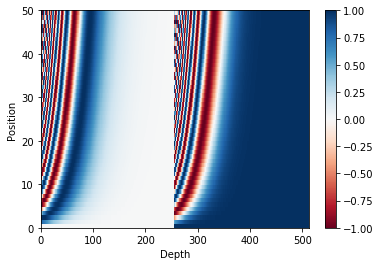

In [30]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [31]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [32]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=217234, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [33]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [34]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=217250, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### ATTENTION
The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

𝐴𝑡𝑡𝑒𝑛𝑡𝑖𝑜𝑛(𝑄,𝐾,𝑉)=𝑠𝑜𝑓𝑡𝑚𝑎𝑥𝑘(𝑄𝐾𝑇𝑑𝑘‾‾‾√)𝑉 
The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that Q and K have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. Hence, square root of dk is used for scaling (and not any other number) because the matmul of Q and K should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [35]:
def scaled_dot_product_attention(q, k, v, mask):
        """Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead) 
        but it must be broadcastable for addition.

        Args:
         q: query shape == (..., seq_len_q, depth)
         k: key shape == (..., seq_len_k, depth)
         v: value shape == (..., seq_len_v, depth_v)
         mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

        Returns:
         output, attention_weights
        """

        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

        # scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # add the mask to the scaled tensor.
        if mask is not None:
              scaled_attention_logits += (mask * -1e9)

        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

        output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth_v)

        return output, attention_weights

### Multi-head attention consists of four parts:

Linear layers and split into heads.
Scaled dot-product attention.
Concatenation of heads.
Final linear layer.
Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The scaled_dot_product_attention defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)

        return output, attention_weights

In [37]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 64, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 64, 512]), TensorShape([1, 8, 64, 64]))

#### Point wise feed forward network
Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [38]:
def point_wise_feed_forward_network(d_model, dff):
      return tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
          tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
      ])

In [39]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

#### The transformer model follows the same general pattern as a standard sequence to sequence with attention model.

The input sentence is passed through N encoder layers that generates an output for each word/token in the sequence.
The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.
Encoder layer
Each encoder layer consists of sublayers:

Multi-head attention (with padding mask)
Point wise feed forward networks.
Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis. There are N encoder layers in the transformer.

In [40]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.experimental.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.experimental.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)        

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [41]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Encoder
The Encoder consists of:

Input Embedding
Positional Encoding
N encoder layers
The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [42]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                   rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x  # (batch_size, input_seq_len, d_model)

In [43]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Create the Transformer
Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [44]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                   target_vocab_size, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, rate)

        self.dense1 = tf.keras.layers.Dense(d_model, activation='tanh')
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')
        

    def call(self, inp, training, enc_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)

        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        enc_output = self.dense1(enc_output[:,0])
        enc_output = self.dropout1(enc_output, training=training)
        final_output = self.final_layer(enc_output)

        return final_output

In [45]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out = sample_transformer(temp_input, training=False, 
                               enc_padding_mask=None)

fn_out.shape  # (batch_size)

TensorShape([64, 1])

In [ ]:
fn_out

### Set hyperparameters
To keep this example small and relatively fast, the values for num_layers, d_model, and dff have been reduced.

The values used in the base model of transformer were; num_layers=6, d_model = 512, dff = 2048. See the paper for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [47]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8

input_vocab_size = tokenizer_sent.vocab_size + 2
target_vocab_size = tokenizer_sent.vocab_size + 2
dropout_rate = 0.1

### Optimizer
Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper.

𝑙𝑟𝑎𝑡𝑒=𝑑−0.5𝑚𝑜𝑑𝑒𝑙∗𝑚𝑖𝑛(𝑠𝑡𝑒𝑝_𝑛𝑢𝑚−0.5,𝑠𝑡𝑒𝑝_𝑛𝑢𝑚∗𝑤𝑎𝑟𝑚𝑢𝑝_𝑠𝑡𝑒𝑝𝑠−1.5)

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [49]:
learning_rate = CustomSchedule(d_model)
#learning_rate = 0.00015

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

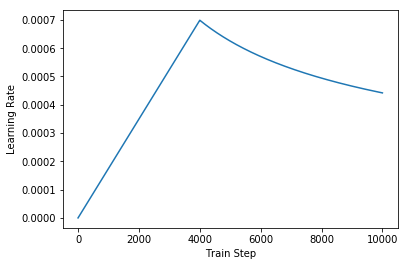

In [50]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(10000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss and metrics
Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [51]:
loss_object = tf.keras.losses.BinaryCrossentropy()

In [52]:
def loss_function(real, pred):
    return loss_object(real,pred)

In [53]:
l = loss_function(label_batch, fn_out)
print("Loss test: {}".format(l))

Loss test: 0.7698262333869934


In [54]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(
    name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(
    name='val_accuracy')

### Training and checkpointing

In [55]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

In [56]:
def create_masks(inp):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    return enc_padding_mask

#### Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.

In [57]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [58]:
# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
val_loss_results = []
val_accuracy_results = []

In [62]:
EPOCHS = 10

In [60]:
@tf.function
def train_step(inp, tar):
    enc_padding_mask = create_masks(inp)

    with tf.GradientTape() as tape:
        predictions = transformer(inp, True, enc_padding_mask)
        loss = loss_function(tar, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar, predictions)

In [61]:
@tf.function
def val_step(inp, tar):
    enc_padding_mask = create_masks(inp)
    predictions = transformer(inp, False, enc_padding_mask)
    loss = loss_function(tar, predictions)
    val_loss(loss)
    val_accuracy(tar, predictions)

In [105]:
#train_step(sent_batch, label_batch)

In [63]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # inp -> imdb comments, tar -> polarity of the comments
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 20 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    
    for (batch, (inp, tar)) in enumerate(val_dataset):
        val_step(inp, tar)
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Epoch {} Train_Loss {:.4f} Train_Accuracy {:.4f} Val_Loss {:.4f} Val_Accuracy {:.4f}'.format(epoch + 1, 
                                                    train_loss.result(), 
                                                    train_accuracy.result(),
                                                    val_loss.result(),
                                                    val_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    # end epoch
    train_loss_results.append(train_loss.result())
    train_accuracy_results.append(train_accuracy.result())
    val_loss_results.append(val_loss.result())
    val_accuracy_results.append(val_accuracy.result())

Epoch 1 Batch 0 Loss 0.7242 Accuracy 0.5000
Epoch 1 Batch 20 Loss 0.7479 Accuracy 0.4836
Epoch 1 Batch 40 Loss 0.7301 Accuracy 0.5034
Epoch 1 Batch 60 Loss 0.7233 Accuracy 0.5059
Epoch 1 Batch 80 Loss 0.7217 Accuracy 0.5060
Epoch 1 Batch 100 Loss 0.7225 Accuracy 0.5096
Epoch 1 Batch 120 Loss 0.7186 Accuracy 0.5177
Epoch 1 Batch 140 Loss 0.7170 Accuracy 0.5183
Epoch 1 Train_Loss 0.7173 Train_Accuracy 0.5194 Val_Loss 0.7574 Val_Accuracy 0.4900
Time taken for 1 epoch: 155.58440947532654 secs

Epoch 2 Batch 0 Loss 0.7198 Accuracy 0.5312
Epoch 2 Batch 20 Loss 0.6959 Accuracy 0.5461
Epoch 2 Batch 40 Loss 0.6927 Accuracy 0.5522
Epoch 2 Batch 60 Loss 0.7001 Accuracy 0.5505
Epoch 2 Batch 80 Loss 0.6912 Accuracy 0.5621
Epoch 2 Batch 100 Loss 0.6871 Accuracy 0.5696
Epoch 2 Batch 120 Loss 0.6726 Accuracy 0.5892
Epoch 2 Batch 140 Loss 0.6575 Accuracy 0.6049
Epoch 2 Train_Loss 0.6458 Train_Accuracy 0.6164 Val_Loss 0.6568 Val_Accuracy 0.6465
Time taken for 1 epoch: 128.04944705963135 secs

Epoch 3 Ba

#### Visualize the loss function over time
While it's helpful to print out the model's training progress, it's often more helpful to see this progress. TensorBoard is a nice visualization tool that is packaged with TensorFlow, but we can create basic charts using the matplotlib module.

Interpreting these charts takes some experience, but you really want to see the loss go down and the accuracy go up.

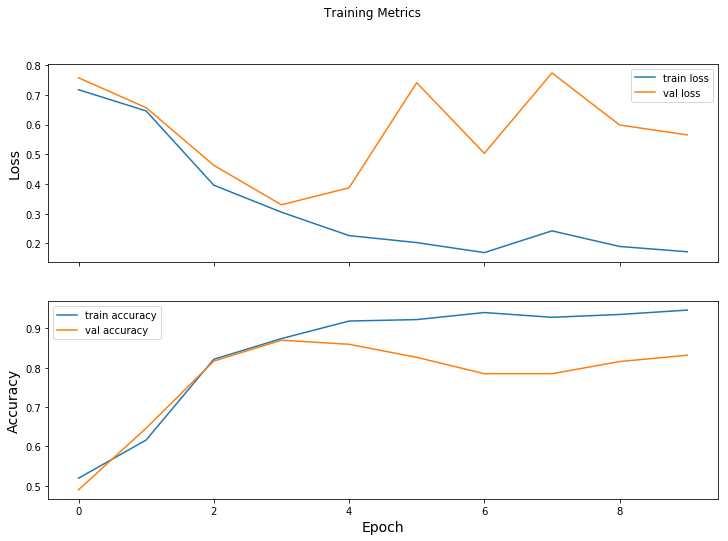

In [64]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results,label='train loss')
axes[0].plot(val_loss_results, label='val loss')
axes[0].legend()

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results, label='train accuracy')
axes[1].plot(val_accuracy_results, label='val accuracy')
axes[1].legend()
plt.show()

In [63]:
transformer.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  16801280  
_________________________________________________________________
dense_62 (Dense)             multiple                  262656    
_________________________________________________________________
dropout_22 (Dropout)         multiple                  0         
_________________________________________________________________
dense_63 (Dense)             multiple                  513       
Total params: 17,064,449
Trainable params: 17,064,449
Non-trainable params: 0
_________________________________________________________________


In [90]:
transformer.fit(
    train_dataset.make_one_shot_iterator(),
    steps_per_epoch=len(x_train) // 128,
    epochs=1,
    verbose = 1)

AttributeError: 'PrefetchDataset' object has no attribute 'make_one_shot_iterator'

In [ ]:
#transformer.layers[1].get_weights()

##### Experimenting with Multi GPU loading of Model

In [77]:
from tensorflow.keras import layers

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  model = tf.keras.Sequential()
  model.add(layers.Dense(16, activation='relu', input_shape=(10,)))
  model.add(layers.Dense(1, activation='sigmoid'))

  optimizer = tf.keras.optimizers.SGD(0.2)

  model.compile(loss='binary_crossentropy', optimizer=optimizer)

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 16)                176       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 17        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [78]:
x = np.random.random((1024, 10))
y = np.random.randint(2, size=(1024, 1))
x = tf.cast(x, tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=1024).batch(32)

model.fit(dataset, epochs=1)

32/32 [==============================] - 2s 69ms/step - loss: 0.7009
